In [1]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import sklearn.metrics as mt
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
import sklearn.svm as svm
from numpy import array
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
experimentNum = 9
experimentIdx = 1
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [4]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [5]:
len(trialsByClasses[0]["left"][0])

69

In [6]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [7]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=8, 
                                                                cutoff_high=12)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [8]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

In [21]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [23]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [24]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [27]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [28]:
len(CSP_passed_left_data)

25

In [29]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [30]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]

(25, 1875, 49)


In [31]:
array(CSP_passed_left_data).shape

(25, 49, 1875)

In [32]:
CSP_passed_left_data = array([i.T for i in array(CSP_passed_left_data).T]).T
CSP_passed_right_data = array([i.T for i in array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = array([i.T for i in array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = array([i.T for i in array(CSP_passed_foot_data).T]).T

In [33]:
from math import log
m = 3
print(minTrialsNum)

leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
tongueVar = np.array([np.array([np.var(CSP_passed_tongue_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
footVar = np.array([np.array([np.var(CSP_passed_foot_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])


leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
tongueVarRatio = np.array([np.array([log(tongueVar[i][j-m]/sum(tongueVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
footVarRatio = np.array([np.array([log(footVar[i][j-m]/sum(footVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])

49


In [34]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
tongueVarRatioDF = pd.DataFrame(tongueVarRatio)
footVarRatioDF = pd.DataFrame(footVarRatio)

labelDF = pd.DataFrame([0]*minTrialsNum + [1]*minTrialsNum + [2]*minTrialsNum + [3]*minTrialsNum)

In [35]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-3.762156,-3.189850,-3.537371,-3.122567,-3.208517,-3.115111,0
1,-4.030470,-3.363194,-3.545632,-3.072416,-3.362943,-3.130080,0
2,-4.124685,-3.064685,-3.570602,-3.126441,-3.333284,-3.198472,0
3,-4.150354,-3.388788,-3.890654,-3.099260,-3.220776,-3.036040,0
4,-4.327300,-2.914928,-3.620316,-3.028567,-3.343131,-3.075209,0
...,...,...,...,...,...,...,...
191,-4.246292,-3.314523,-3.646855,-3.168076,-3.503948,-3.227071,3
192,-4.170826,-3.019934,-3.453122,-3.094983,-3.341194,-3.187790,3
193,-4.312011,-2.828695,-3.652258,-2.913567,-3.323124,-3.058462,3
194,-3.743648,-3.189433,-3.770949,-3.057367,-3.379514,-3.129107,3


In [36]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,1.761539,-0.638824,0.230292,-1.150707,1.162483,-0.396212
1,0.116594,-1.356044,0.167928,-0.491821,-0.742232,-0.642529
2,-0.461005,-0.120950,-0.020581,-1.201597,-0.376408,-1.767929
3,-0.618376,-1.461942,-2.436805,-0.844506,1.011271,0.904923
4,-1.703172,0.498675,-0.395895,0.084264,-0.497866,0.260389
...,...,...,...,...,...,...
191,-1.206541,-1.154668,-0.596251,-1.748596,-2.481400,-2.238535
192,-0.743884,0.064209,0.866328,-0.788312,-0.473968,-1.592150
193,-1.609445,0.855468,-0.637041,1.595121,-0.251093,0.535968
194,1.875006,-0.637101,-1.533099,-0.294115,-0.946610,-0.626504


In [37]:
n_componunts = 5
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [38]:
sum(PCA.explained_variance_ratio_())

0.9771661101552165

In [39]:
pd.concat([principalDF, labelDF], axis=1)

,principal component1,principal component2,principal component3,principal component4,principal component5,0
0,-0.290983,0.298684,-1.557920,1.840690,-0.613680,0
1,1.221654,0.063546,-1.177898,-0.116045,0.401310,0
2,1.892673,0.622531,0.074832,0.524026,-0.499189,0
3,0.577002,-3.089357,-0.201469,1.021679,-0.013117,0
4,0.644592,-0.597518,1.288208,-1.042179,-0.234597,0
...,...,...,...,...,...,...
191,4.095393,0.437833,-0.135600,-0.173152,0.588610,3
192,1.528284,1.105685,0.046599,-0.302739,-0.745417,3
193,-0.496160,-0.768385,1.836534,-1.438561,0.522412,3
194,0.677020,0.042921,-0.626329,1.771696,1.891777,3


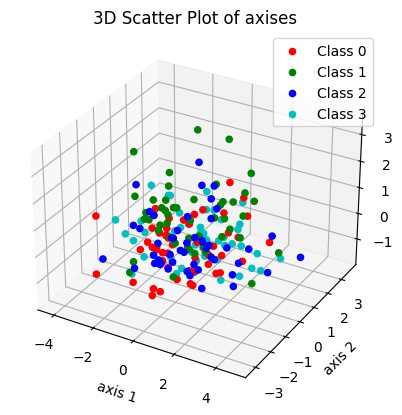

,axis1,axis2,axis3,axis4,axis5,label
0,-0.290983,0.298684,-1.557920,1.840690,-0.613680,0
1,1.221654,0.063546,-1.177898,-0.116045,0.401310,0
2,1.892673,0.622531,0.074832,0.524026,-0.499189,0
3,0.577002,-3.089357,-0.201469,1.021679,-0.013117,0
4,0.644592,-0.597518,1.288208,-1.042179,-0.234597,0
...,...,...,...,...,...,...
191,4.095393,0.437833,-0.135600,-0.173152,0.588610,3
192,1.528284,1.105685,0.046599,-0.302739,-0.745417,3
193,-0.496160,-0.768385,1.836534,-1.438561,0.522412,3
194,0.677020,0.042921,-0.626329,1.771696,1.891777,3


In [40]:
# 데이터를 DataFrame으로 생성
df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(df ,4)
df

In [41]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(principalDF, labelDF, 3, "eigen")), labelDF], axis=1)

In [42]:
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [43]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [44]:
np.save(f"./data/raw/dataframe_raw_{experimentIdx}", LDA_DF)

In [45]:
# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
svm_clf = svm.SVC(kernel = 'rbf')

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)
scores

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.39333333333333337
교차검증 평균:  0.39871794871794874
